In [1]:
import numpy as np
import pandas as pd
import os
import argparse
import errno
import scipy.misc
import dlib
import cv2

from skimage.feature import hog
import matplotlib.pyplot as plt
from PIL import Image


In [2]:
# initialization
image_height = 48
image_width = 48
window_size = 24
window_step = 6
ONE_HOT_ENCODING = False
SAVE_IMAGES = False
GET_LANDMARKS = True
GET_HOG_FEATURES = True
GET_HOG_IMAGES = True
GET_HOG_WINDOWS_FEATURES = True
SELECTED_LABELS = []

expressions = [0,1,2,3,4,5,6]
for i in range(0,len(expressions)):
    label = int(expressions[i])
    if (label >=0 and label<=6 ):
        SELECTED_LABELS.append(label)
        
if SELECTED_LABELS == []:
    SELECTED_LABELS = [0,1,2,3,4,5,6]
print( str(len(SELECTED_LABELS)) + " expressions")

IMAGES_PER_LABEL = 450
OUTPUT_FOLDER_NAME = "fer2013"




7 expressions


In [3]:
# loading Dlib predictor and preparing arrays:
print( "preparing")
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
original_labels = [0, 1, 2, 3, 4, 5, 6]
new_labels = list(set(original_labels) & set(SELECTED_LABELS))
nb_images_per_label = list(np.zeros(len(new_labels), 'uint8'))

try:
    os.makedirs(OUTPUT_FOLDER_NAME)
except OSError as e:
    if e.errno == errno.EEXIST and os.path.isdir(OUTPUT_FOLDER_NAME):
        pass
    else:
        raise

def get_landmarks(image, rects):
    # this function have been copied from http://bit.ly/2cj7Fpq
    if len(rects) > 1:
        raise BaseException("TooManyFaces")
    if len(rects) == 0:
        raise BaseException("NoFaces")
    return np.matrix([[p.x, p.y] for p in predictor(image, rects[0]).parts()])

def get_new_label(label, one_hot_encoding=False):
    if one_hot_encoding:
        new_label = new_labels.index(label)
        label = list(np.zeros(len(new_labels), 'uint8'))
        label[new_label] = 1
        return label
    else:
        return new_labels.index(label)

def sliding_hog_windows(image):
    hog_windows = []
    for y in range(0, image_height, window_step):
        for x in range(0, image_width, window_step):
            window = image[y:y+window_size, x:x+window_size]
            hog_windows.extend(hog(window, orientations=8, pixels_per_cell=(8, 8),
                                            cells_per_block=(1, 1), visualise=False))
    return hog_windows

print( "importing csv file")
data = pd.read_csv('fer2013.csv')

for category in data['Usage'].unique():
    print( "converting set: " + category + "...")
    # create folder
    if not os.path.exists(category):
        try:
            os.makedirs(OUTPUT_FOLDER_NAME + '\\' + category)
        except OSError as e:
            if e.errno == errno.EEXIST and os.path.isdir(OUTPUT_FOLDER_NAME):
                pass
            else:
                raise
    
    # get samples and labels of the actual category
    category_data = data[data['Usage'] == category]
    samples = category_data['pixels'].values
    labels = category_data['emotion'].values
    
    # get images and extract features
    images = []
    labels_list = []
    landmarks = []
    hog_features = []
    hog_images = []
    for i in range(len(samples)):
        try:
            if labels[i] in SELECTED_LABELS and nb_images_per_label[get_new_label(labels[i])] < IMAGES_PER_LABEL:

                image = np.fromstring(samples[i], dtype=int, sep=" ").reshape((image_height, image_width))
                images.append(image)
                if SAVE_IMAGES:

                    cv2.imwrite('.\\{}\\{}.jpg'.format(category,i), image) 
                    print('.\\{}\\{}.jpg'.format(category,i))
                    
                if GET_HOG_WINDOWS_FEATURES:
                    features = sliding_hog_windows(image)
                    f, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                                            cells_per_block=(1, 1), visualise=True)
                    hog_features.append(features)
                    if GET_HOG_IMAGES:
                        hog_images.append(hog_image)
                elif GET_HOG_FEATURES:
                    features, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                                            cells_per_block=(1, 1), visualise=True)
                    hog_features.append(features)
                    if GET_HOG_IMAGES:
                        hog_images.append(hog_image)
                if GET_LANDMARKS:
                    cv2.imwrite('temp.jpg', image)
                    image2 = cv2.imread('temp.jpg')
                    face_rects = [dlib.rectangle(left=1, top=1, right=47, bottom=47)]
                    face_landmarks = get_landmarks(image2, face_rects)
                    landmarks.append(face_landmarks)            
                labels_list.append(get_new_label(labels[i], one_hot_encoding=ONE_HOT_ENCODING))
                nb_images_per_label[get_new_label(labels[i])] += 1
        except Exception as e:
            print( "error in image: " + str(i) + " - " + str(e))

    np.save(OUTPUT_FOLDER_NAME + '\\' + category + '\\images.npy', images)
    if ONE_HOT_ENCODING:
        np.save(OUTPUT_FOLDER_NAME + '\\' + category + '\\labels.npy', labels_list)
    else:
        np.save(OUTPUT_FOLDER_NAME + '\\' + category + '\\labels.npy', labels_list)
    if GET_LANDMARKS:
        np.save(OUTPUT_FOLDER_NAME + '\\' + category + '\\landmarks.npy', landmarks)
    if GET_HOG_FEATURES or GET_HOG_WINDOWS_FEATURES:
        np.save(OUTPUT_FOLDER_NAME + '\\' + category + '\\hog_features.npy', hog_features)
        if GET_HOG_IMAGES:
            np.save(OUTPUT_FOLDER_NAME + '\\' + category + '\\hog_images.npy', hog_images)

preparing
importing csv file
converting set: Training...


C:\Users\hoanganh\Anaconda3\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
C:\Users\hoanganh\Anaconda3\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


converting set: PublicTest...
converting set: PrivateTest...


In [4]:
from parameters import DATASET, NETWORK
import numpy as np

def load_data(validation=False, test=False):
    
    data_dict = dict()
    validation_dict = dict()
    test_dict = dict()

    if DATASET.name == "fer2013":

        # load train set
        data_dict['X'] = np.load(DATASET.train_folder + '/images.npy')
        data_dict['X'] = data_dict['X'].reshape([-1, NETWORK.input_size, NETWORK.input_size, 1])
        if NETWORK.use_landmarks:
            data_dict['X2'] = np.load(DATASET.train_folder + '/landmarks.npy')
        if NETWORK.use_hog_and_landmarks:
            data_dict['X2'] = np.load(DATASET.train_folder + '/landmarks.npy')
            data_dict['X2'] = np.array([x.flatten() for x in data_dict['X2']])
            data_dict['X2'] = np.concatenate((data_dict['X2'], np.load(DATASET.train_folder + '/hog_features.npy')), axis=1)
        data_dict['Y'] = np.load(DATASET.train_folder + '/labels.npy')
        if DATASET.trunc_trainset_to > 0:
            data_dict['X'] = data_dict['X'][0:DATASET.trunc_trainset_to, :, :]
            if NETWORK.use_landmarks and NETWORK.use_hog_and_landmarks:
                data_dict['X2'] = data_dict['X2'][0:DATASET.trunc_trainset_to, :]
            elif NETWORK.use_landmarks:
                data_dict['X2'] = data_dict['X2'][0:DATASET.trunc_trainset_to, :, :]
            data_dict['Y'] = data_dict['Y'][0:DATASET.trunc_trainset_to, :]

        if validation:
            # load validation set
            validation_dict['X'] = np.load(DATASET.validation_folder + '/images.npy')
            validation_dict['X'] = validation_dict['X'].reshape([-1, NETWORK.input_size, NETWORK.input_size, 1])
            if NETWORK.use_landmarks:
                validation_dict['X2'] = np.load(DATASET.validation_folder + '/landmarks.npy')
            if NETWORK.use_hog_and_landmarks:
                validation_dict['X2'] = np.load(DATASET.validation_folder + '/landmarks.npy')
                validation_dict['X2'] = np.array([x.flatten() for x in validation_dict['X2']])
                validation_dict['X2'] = np.concatenate((validation_dict['X2'], np.load(DATASET.validation_folder + '/hog_features.npy')), axis=1)
            validation_dict['Y'] = np.load(DATASET.validation_folder + '/labels.npy')
            if DATASET.trunc_validationset_to > 0:
                validation_dict['X'] = validation_dict['X'][0:DATASET.trunc_validationset_to, :, :]
                if NETWORK.use_landmarks and NETWORK.use_hog_and_landmarks:
                    validation_dict['X2'] = validation_dict['X2'][0:DATASET.trunc_validationset_to, :]
                elif NETWORK.use_landmarks:
                    validation_dict['X2'] = validation_dict['X2'][0:DATASET.trunc_validationset_to, :, :]
                validation_dict['Y'] = validation_dict['Y'][0:DATASET.trunc_validationset_to, :]
        
        if test:
            # load test set
            test_dict['X'] = np.load(DATASET.test_folder + '/images.npy')
            test_dict['X'] = test_dict['X'].reshape([-1, NETWORK.input_size, NETWORK.input_size, 1])
            if NETWORK.use_landmarks:
                test_dict['X2'] = np.load(DATASET.test_folder + '/landmarks.npy')
            if NETWORK.use_hog_and_landmarks:
                test_dict['X2'] = np.load(DATASET.test_folder + '/landmarks.npy')
                test_dict['X2'] = np.array([x.flatten() for x in test_dict['X2']])
                test_dict['X2'] = np.concatenate((test_dict['X2'], np.load(DATASET.test_folder + '/hog_features.npy')), axis=1)
            test_dict['Y'] = np.load(DATASET.test_folder + '/labels.npy')
            if DATASET.trunc_testset_to > 0:
                test_dict['X'] = test_dict['X'][0:DATASET.trunc_testset_to, :, :]
                if NETWORK.use_landmarks and NETWORK.use_hog_and_landmarks:
                    test_dict['X2'] = test_dict['X2'][0:DATASET.trunc_testset_to, :]
                elif NETWORK.use_landmarks:
                    test_dict['X2'] = test_dict['X2'][0:DATASET.trunc_testset_to, :, :]
                test_dict['Y'] = test_dict['Y'][0:DATASET.trunc_testset_to, :]

        if not validation and not test:
            return data_dict
        elif not test:
            return data_dict, validation_dict
        else: 
            return data_dict, validation_dict, test_dict
    else:
        print( "Unknown dataset")
        exit()

In [5]:
a = np.load('fer2013/Training/images.npy')
a.shape

(3136, 48, 48)

In [7]:
b = np.load('fer2013/PrivateTest/labels.npy')
b.shape

(0,)

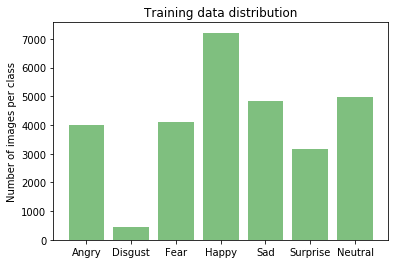

In [15]:


### draw bar chart for training  classes

labels =('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')
y_pos = np.arange(len(labels))
no_train_img = [] 
l = list(b)
for i in range(7):
    no = l.count(i)
    no_train_img.append(no)


plt.bar(y_pos, no_train_img, align='center', alpha=0.5,color='g')
plt.xticks(y_pos, labels)
plt.ylabel('Number of images per class')
plt.title('Training data distribution')
 
plt.show()


(3589,)
[0 1 4 6 3 3 2 0 2 0 3 0 4 2 6 2 5 0 5 3 2 5 0 4 0 2 4 4 0 2 3 6 3 6 0 4 6
 2 6 3 0 4 4 2 6 3 5 3 5 6]


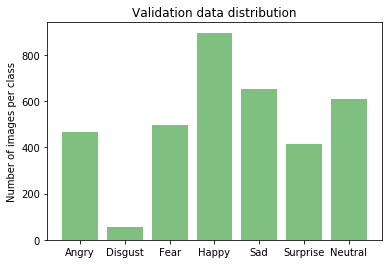

(3589,)
[0 5 6 4 2 0 4 3 0 3 5 3 4 4 0 6 2 5 4 2 3 6 0 6 3 2 5 6 6 3 4 6 6 0 1 3 5
 0 0 4 6 4 2 4 2 4 3 6 3 3]


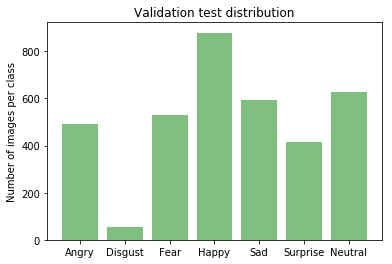

In [20]:

### validation data ###
c = np.load('fer2013/PublicTest/labels.npy')
print(c.shape)
print(c[0:50])

no_valid_img = [] 
l = list(c)
for i in range(7):
    no = l.count(i)
    no_valid_img.append(no)

plt.bar(y_pos, no_valid_img, align='center', alpha=0.5,color='g')
plt.xticks(y_pos, labels)
plt.ylabel('Number of images per class')
plt.title('Validation data distribution')
plt.show()

#### test data #####

d = np.load('fer2013/PrivateTest/labels.npy')
print(d.shape)
print(d[0:50])

no_test_img = [] 
l = list(d)
for i in range(7):
    no = l.count(i)
    no_test_img.append(no)
    
plt.bar(y_pos, no_test_img, align='center', alpha=0.5,color='g')
plt.xticks(y_pos, labels)
plt.ylabel('Number of images per class')
plt.title('Validation test distribution')
plt.show()    

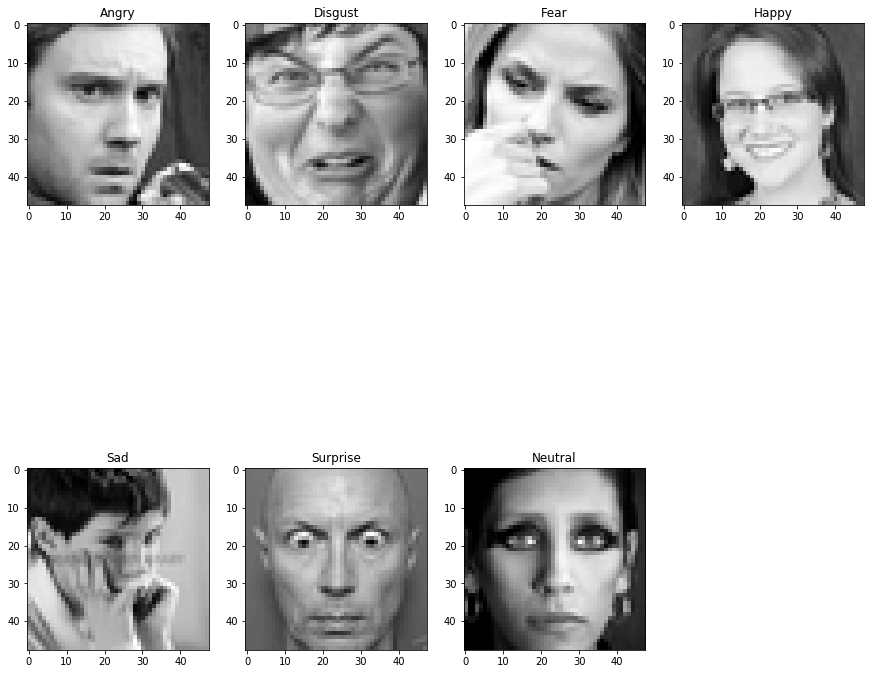

In [51]:

############## display images ###################
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 2
for i in range(7):
    ind = np.nonzero(b == i)[0][0]
    img = a[ind,:,:]
    # print(img)
    fig.add_subplot(rows, columns, i+1)
    implot = plt.imshow(img, cmap='gray')
    implot = plt.title(labels[i], loc='center')


plt.show()


(28709, 68, 2)


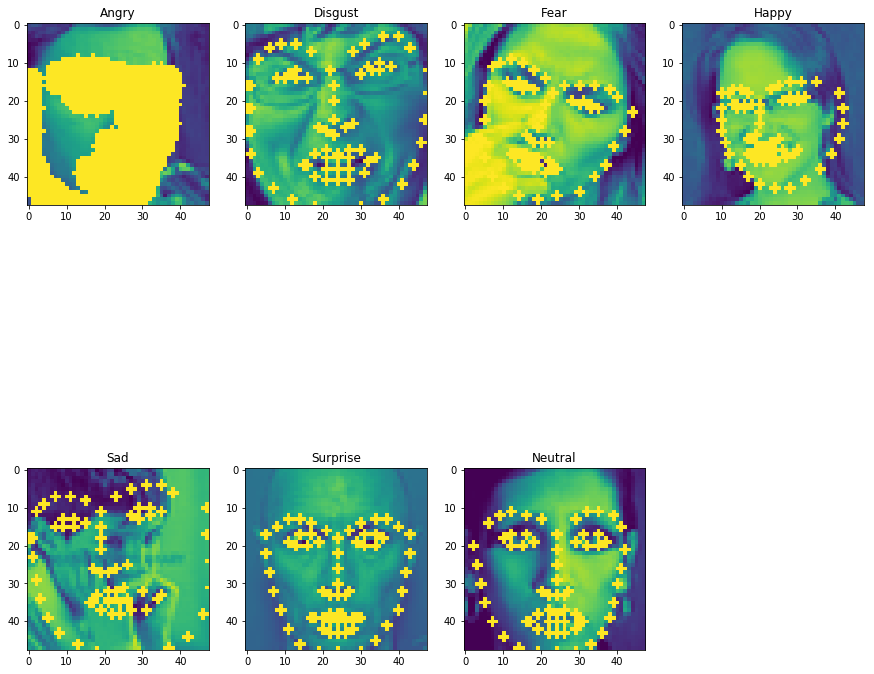

In [98]:
##### display landmarks 
landmasks = np.load('fer2013\\Training\\landmarks.npy')
print(landmasks.shape)




############## display images ###################
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 2


for i in range(7):
    ind = np.nonzero(b == i)[0][0]
    img = a[ind,:,:]
    mask = landmasks[ind]
    for j in range(68):   ## 68 landmarks points    
        cv2.circle(img ,(max(int(mask[j][0]),0),int(mask[j][1])),1,(255,0,0),-1)
    
    # print(img)
    fig.add_subplot(rows, columns, i+1)
    implot = plt.imshow(img)
    implot = plt.title(labels[i], loc='center')


plt.show()
    
    
    

(28709, 2592)
(28709, 48, 48)


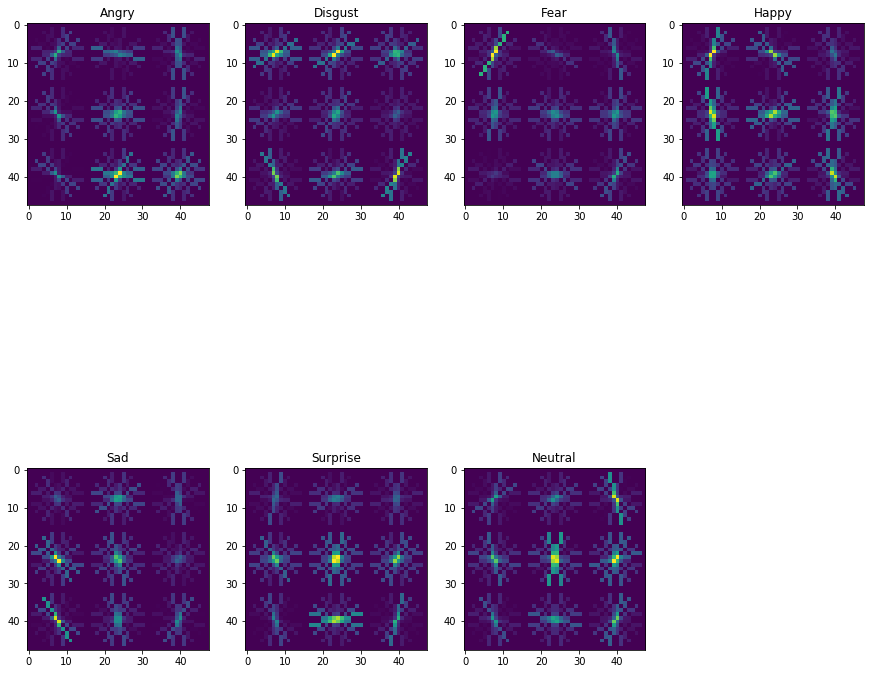

In [107]:
### display hog features

hog_features = np.load('fer2013\\Training\\hog_features.npy')
print(hog_features.shape)
hog_images = np.load('fer2013\\Training\\hog_images.npy')
print(hog_images.shape)


############## display images ###################
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 2
for i in range(7):
    ind = np.nonzero(b == i)[0][0]
    img = hog_images[ind,:,:]
    # print(img)
    fig.add_subplot(rows, columns, i+1)
    implot = plt.imshow(img)   #cmap='gray'
    implot = plt.title(labels[i], loc='center')


plt.show()


In [108]:

###### load  data for  training 


data_dict = dict()
validation_dict = dict()
test_dict = dict()

# load train set
data_dict['X'] = np.load('fer2013\\Training\\images.npy')
data_dict['X'] = data_dict['X'].reshape([-1, NETWORK.input_size, NETWORK.input_size, 1])

if NETWORK.use_landmarks:
    data_dict['X2'] = np.load('fer2013\\Training\\landmarks.npy')
if NETWORK.use_hog_and_landmarks:
    data_dict['X2'] = np.load('fer2013\\Training\\landmarks.npy')
    data_dict['X2'] = np.array([x.flatten() for x in data_dict['X2']])
    data_dict['X2'] = np.concatenate((data_dict['X2'], np.load('fer2013\\Training\\hog_features.npy')), axis=1)
    
data_dict['Y'] = np.load('fer2013\\Training\\labels.npy')

